In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
from scipy import interpolate
from ccfj import GetStationPairs
import pandas as pd
import yaml
import geopandas as gp
import openpyxl
from openpyxl import load_workbook
from concurrent.futures import ThreadPoolExecutor

from scipy.interpolate import make_interp_spline
from scipy.stats import ks_2samp
from scipy.spatial import ConvexHull
from skimage import measure

import warnings

In [2]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import plotlib

In [3]:
#name_project = 'project/output_FJSJ_17-01/'               
name_project = 'project_repartition_v3.0/output_repar_01-01/'               
name_project

'project_repartition_v3.0/output_repar_01-01/'

In [4]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v3.0/output_repar_01-01/


In [5]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [6]:
key_subworks = info_basic['key_subworks']
key_subworks

['07-03--1',
 '09-03--2',
 '10-03--3',
 '11-03--4',
 '12-03--5',
 '13-03--6',
 '14-03--7',
 '16-03--8',
 '17-03--9',
 '18-03--10',
 '19-03--11',
 '20-03--12',
 '21-03--13',
 '22-03--14',
 '23-03--15',
 '24-03--16',
 '25-03--17',
 '26-03--18',
 '27-03--19',
 '28-03--20',
 '29-03--21',
 '31-03--22',
 '32-03--23',
 '34-03--24',
 '36-03--25',
 '37-03--26',
 '38-03--27',
 '39-03--28',
 '40-03--29',
 '41-03--30',
 '43-03--31',
 '45-03--32',
 '46-03--33',
 '47-03--34',
 '48-03--35',
 '49-03--36',
 '52-03--37',
 '53-03--38',
 '54-03--39',
 '07-04--40',
 '08-04--41',
 '09-04--42',
 '10-04--43',
 '11-04--44',
 '12-04--45',
 '14-04--46',
 '15-04--47',
 '16-04--48',
 '18-04--49',
 '19-04--50',
 '20-04--51',
 '21-04--52',
 '22-04--53',
 '23-04--54',
 '24-04--55',
 '25-04--56',
 '26-04--57',
 '27-04--58',
 '28-04--59',
 '29-04--60',
 '30-04--61',
 '31-04--62',
 '32-04--63',
 '33-04--64',
 '36-04--65',
 '39-04--66',
 '40-04--67',
 '43-04--68',
 '45-04--69',
 '46-04--70',
 '47-04--71',
 '48-04--72',
 

In [7]:
dir_image = dir_project+info_basic['dir_image']
dir_ds = dir_project+info_basic['dir_ds']
print('dir_image: ', dir_image)
print('dir_ds: ', dir_ds)

dir_image:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v3.0/output_repar_01-01/image_01-01/
dir_ds:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v3.0/output_repar_01-01/ds_01-01/


In [8]:
dir_disp =  'autopick'+info_basic['tag']+'/'
info_basic['dir_disp'] = dir_disp
dir_disp = dir_project+dir_disp
if not os.path.exists(dir_disp):
    os.makedirs(dir_disp)
print('dir_disp: ', dir_disp)

dir_disp:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v3.0/output_repar_01-01/autopick01-01/


In [9]:
with open(dir_project+'Basic_info.yml', 'w', encoding='utf-8') as f:
   yaml.dump(data=info_basic, stream=f, allow_unicode=True)

### Pick probes' Phase velocity automatically

In [10]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [11]:
def cluster_fundamental(ds):
    global f
    global c
    global f_new
    global c_new
    global dir_ds
    global threshold
    # 归一化
    ds = np.nan_to_num(ds)
    for i in range(ds.shape[1]):
        ds[:,i] = ds[:,i]/np.max(ds[:,i])

    binary_ds = ds > threshold
    label_ds,num_labels = measure.label(binary_ds, connectivity=2, return_num=True)
    region_areas = [np.sum(label_ds==i) for i in range(1,num_labels+1)]
    if num_labels == 0:
        return np.zeros(0),np.zeros(0)
    max_area_label = np.argmax(region_areas) + 1
    largest_cluster = label_ds == max_area_label
    indices = np.argwhere(largest_cluster)

    ff = f_new[indices[:,1]]
    cc = c_new[indices[:,0]]

    return ff,cc

In [12]:
def pick_fundamental(key):
    global f
    global c
    global f_new
    global c_new
    global flag_f
    global flag_c
    global dir_ds
    global threshold
    global dir_disp
    global dir_ds
    global info_basic
    global info_basic_bi
    global smooth_cluster
    global smooth_pick
    global key_subworks
    global ds_remove_all

    
    ds_remove = ds_remove_all[key]
    grace = 0.0

    f_start = flag_f[0]
    f_end = flag_f[1]
    c_min = flag_c[0]
    c_max = flag_c[1]

    ff_all = []
    cc_all = []


    while f_start != f_end:
        #print(f_start,f_end)
        f_new = f[np.logical_and(f>f_start,f <= f_end)]
        c_new = c[np.logical_and(c>c_min,c < c_max)]
        ds_new0 = ds_remove[np.logical_and(c>c_min,c < c_max),:]
        ds_new = ds_new0[:,np.logical_and(f>f_start,f <= f_end)]
        # 对数组进行横向的平滑
        ds_new = pd.DataFrame(ds_new)
        #ds_new = ds_new.rolling(100).mean()
        ds_new = ds_new.T
        ds_new = ds_new.rolling(smooth_cluster).mean()
        ds_new = np.array(ds_new)
        ds_new = ds_new.T
        ff,cc = cluster_fundamental(ds_new)
        if len(ff_all) == 0:
            ff_all = ff
            cc_all = cc
        elif len(ff) != 0:
            ff_all = np.hstack((ff_all,ff))
            cc_all = np.hstack((cc_all,cc))
        else:
            #print('this')
            break
        f_start = np.max(ff)
        c_max = np.max(cc[ff==f_start]) + grace
    
    # smooth
    # 转置
    ds_smooth = ds_remove.T
    ds_smooth = pd.DataFrame(ds_smooth)
    ds_smooth = ds_smooth.rolling(smooth_pick).mean()
    ds_smooth = np.array(ds_smooth)
    ds_smooth = ds_smooth.T
    ds_smooth = pd.DataFrame(ds_smooth)
    ds_smooth = ds_smooth.rolling(smooth_pick).mean()
    ds_smooth = np.array(ds_smooth)

    f_range = set(ff_all)
    f_range = list(f_range)
    c_pick = []
    for i in range(len(f_range)):
        f_this = f_range[i]
        c_this = cc_all[ff_all==f_this]
        c_range = [np.min(c_this),np.max(c_this)]
        c_new = c[np.logical_and(c>=c_range[0],c<=c_range[1])]
        c_pick.append(c_new[np.argmax(ds_smooth[np.logical_and(c>=c_range[0],c<=c_range[1]),f==f_this])])
    
    # save as txt
    np.savetxt(dir_disp+'autopick_cluster_'+key+'.txt', np.array([ff_all,cc_all]).T, fmt='%.4f', delimiter=',')
    np.savetxt(dir_disp+'autopick_'+key+'.txt', np.array([f_range,c_pick]).T, fmt='%.4f', delimiter=',')
    print('finish '+ key + ' '+str(key_subworks.index(key)+1) + '/'+str(len(key_subworks)))

In [13]:
key_subworks_all = info_basic['key_subworks']
key_subworks = []
for key in key_subworks_all:
    if int(key[0:2]) >= 46:
        key_subworks.append(key)
key_subworks = ['51-17--646']
key_subworks = info_basic['key_subworks'][600:]
key_subworks

['50-16--601',
 '51-16--602',
 '52-16--603',
 '53-16--604',
 '54-16--605',
 '07-17--606',
 '08-17--607',
 '09-17--608',
 '11-17--609',
 '12-17--610',
 '14-17--611',
 '15-17--612',
 '16-17--613',
 '17-17--614',
 '18-17--615',
 '19-17--616',
 '20-17--617',
 '21-17--618',
 '22-17--619',
 '23-17--620',
 '24-17--621',
 '25-17--622',
 '26-17--623',
 '27-17--624',
 '28-17--625',
 '29-17--626',
 '30-17--627',
 '31-17--628',
 '33-17--629',
 '34-17--630',
 '35-17--631',
 '36-17--632',
 '37-17--633',
 '38-17--634',
 '40-17--635',
 '41-17--636',
 '42-17--637',
 '43-17--638',
 '44-17--639',
 '45-17--640',
 '46-17--641',
 '47-17--642',
 '48-17--643',
 '50-17--644',
 '51-17--645',
 '52-17--646',
 '53-17--647',
 '54-17--648',
 '07-18--649',
 '08-18--650',
 '09-18--651',
 '11-18--652',
 '12-18--653',
 '13-18--654',
 '15-18--655',
 '16-18--656',
 '17-18--657',
 '18-18--658',
 '19-18--659',
 '20-18--660',
 '21-18--661',
 '22-18--662',
 '24-18--663',
 '28-18--664',
 '29-18--665',
 '33-18--666',
 '34-18--6

In [14]:
ds_remove_all = {}
for key_subwork in key_subworks:
    ds = h5py.File(dir_ds+'ds_'+key_subwork+'.h5', 'r')
    ds_remove = ds['ds_remove'][0]
    ds.close()
    ds_remove_all[key_subwork] = ds_remove

In [15]:
f = info_basic_bi['f']
c = np.linspace(info_basic['c_min'],info_basic['c_max'],info_basic['c_num'])
flag_c = [0.1,1.5]
flag_f = [2.5,20]
threshold = 0.5
f_new = f[np.logical_and(f>flag_f[0],f < flag_f[1])]
c_new = c[np.logical_and(c>flag_c[0],c < flag_c[1])]
smooth_cluster = 3
smooth_pick = 1
flag_pick = 1

In [16]:
warnings.filterwarnings("ignore")
if flag_pick == 1:
    for key_subwork in key_subworks:
        pick_fundamental(key_subwork)

finish 50-16--601 1/82
finish 51-16--602 2/82
finish 52-16--603 3/82
finish 53-16--604 4/82
finish 54-16--605 5/82
finish 07-17--606 6/82
finish 08-17--607 7/82
finish 09-17--608 8/82
finish 11-17--609 9/82
finish 12-17--610 10/82
finish 14-17--611 11/82
finish 15-17--612 12/82
finish 16-17--613 13/82
finish 17-17--614 14/82
finish 18-17--615 15/82
finish 19-17--616 16/82
finish 20-17--617 17/82
finish 21-17--618 18/82
finish 22-17--619 19/82
finish 23-17--620 20/82
finish 24-17--621 21/82
finish 25-17--622 22/82
finish 26-17--623 23/82
finish 27-17--624 24/82
finish 28-17--625 25/82
finish 29-17--626 26/82
finish 30-17--627 27/82
finish 31-17--628 28/82
finish 33-17--629 29/82
finish 34-17--630 30/82
finish 35-17--631 31/82
finish 36-17--632 32/82
finish 37-17--633 33/82
finish 38-17--634 34/82
finish 40-17--635 35/82
finish 41-17--636 36/82
finish 42-17--637 37/82
finish 43-17--638 38/82
finish 44-17--639 39/82
finish 45-17--640 40/82
finish 46-17--641 41/82
finish 47-17--642 42/82
f

In [17]:
def plot_disp(key_subwork):
    global dir_disp
    global f
    global c
    global dir_image_disp

    fig,ax = plt.subplots(1,2,figsize=(16,6))
    dir_ds = dir_project + info_basic['dir_ds']
    ds = h5py.File(dir_ds+'ds_'+key_subwork+'.h5', 'r')
    ds_remove = ds['ds_remove'][0]

    title0 = key_subwork
    ff_all = np.loadtxt(dir_disp+'autopick_cluster_'+key_subwork+'.txt',delimiter=',')[:,0]
    cc_all = np.loadtxt(dir_disp+'autopick_cluster_'+key_subwork+'.txt',delimiter=',')[:,1]
    f_pick = np.loadtxt(dir_disp+'autopick_'+key_subwork+'.txt',delimiter=',')[:,0]
    c_pick = np.loadtxt(dir_disp+'autopick_'+key_subwork+'.txt',delimiter=',')[:,1]

    ax[0] = plotlib.plot_fj(ax[0],ds_remove,title0,f,c,0,c_map='jet')
    ax[0].scatter(ff_all,cc_all,marker='o',s=10,color='k')
    
    ax[1] = plotlib.plot_fj(ax[1],ds_remove,title0,f,c,0,c_map='jet')
    ax[1].scatter(f_pick,c_pick,marker='o',s=10,color='k')

    plt.savefig(dir_image_disp+'autopick_'+key_subwork+'.png',dpi=60)
    plt.tight_layout()
    #plt.close()
    print('finish '+key_subwork)

In [18]:
dir_image_disp = 'image_autopick/'
if not os.path.exists(dir_project+dir_image_disp):
    os.makedirs(dir_project+dir_image_disp)
dir_image_disp = dir_project+dir_image_disp

In [19]:
flag_plot = 1

In [20]:
key_subworks = key_subworks[0:3]

finish 50-16--601
finish 51-16--602
finish 52-16--603


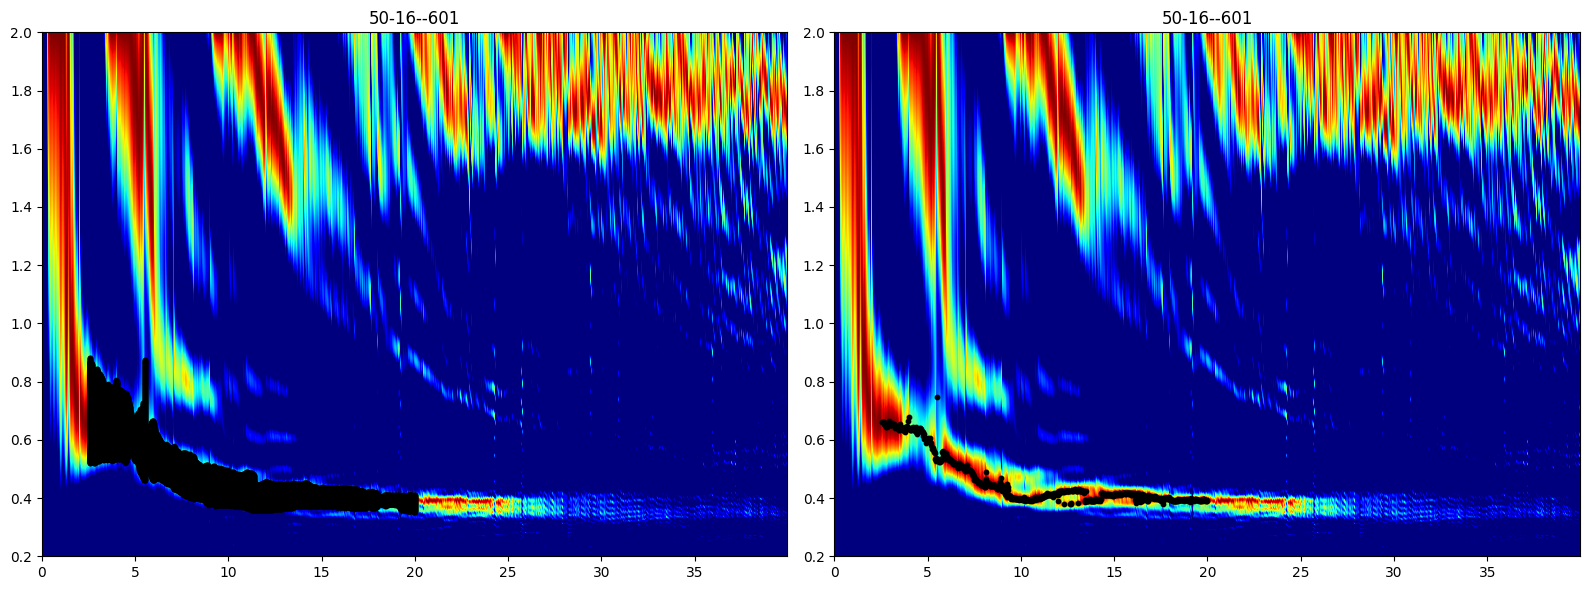

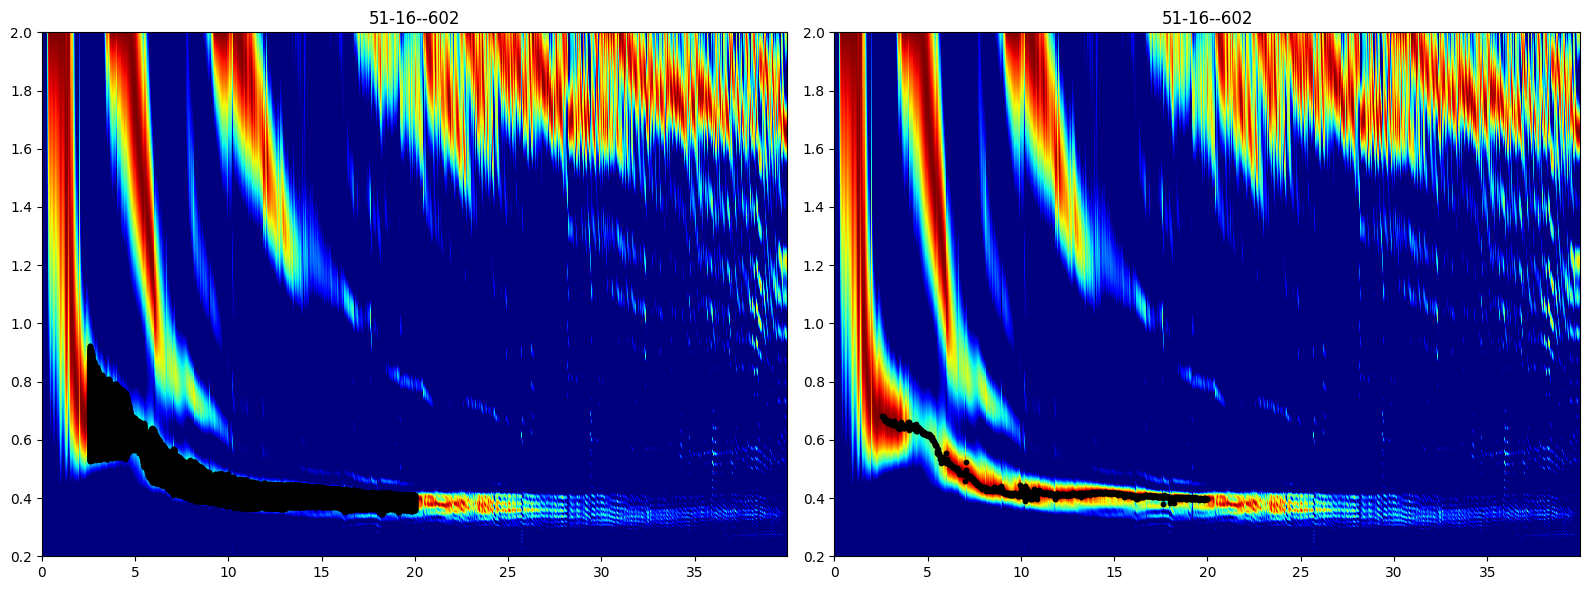

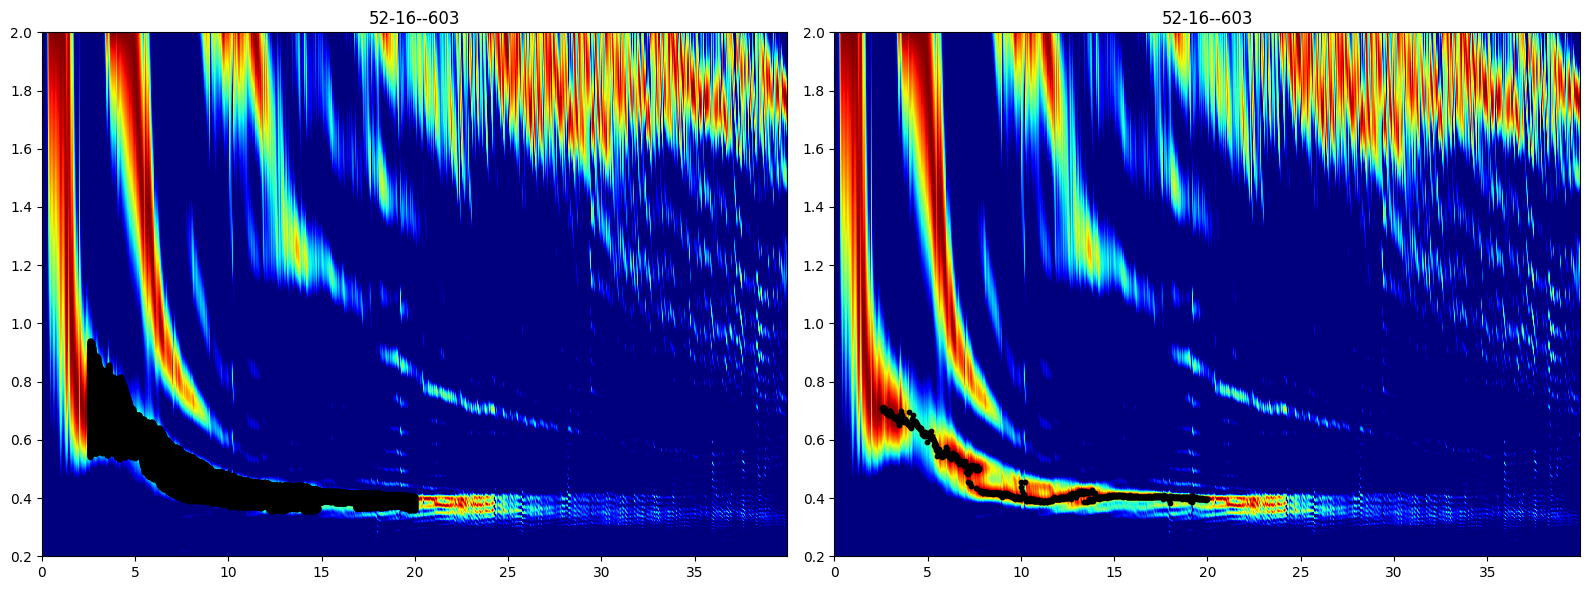

In [21]:
if flag_plot == 1:
    for key_subwork in key_subworks:
        plot_disp(key_subwork)